# A/B Testing
### Why? 
Typically, A/B tests are run to improve Key Performance Indicators(KPIs).  

We need to define a **response variable** that we will use to measure our impact. This should be either a KPI or something directly related to a KPI.  

**Calculating experimental units** first, in order to have baseline values related to our assumption.


### Core Concepts for design and analyze an experiment:

#### 1. Ask clarifying questions to understand **business goals** and **product feature** details as well.

#### 2. State Business Hypothesis, Null Hypothesis, & define metrics to be evaluated.

  - H0, Null hypothesis: general situation. (As a testers, we don’t want H0 to be true.)
  - H1, Alternative hypothesis: something against general situation, the researcher want to proof it. 
##### Hypothesis  (backed up by data) about what you can change to improve it.

   - Primary metric
   - Secondary metrics
   - Guardrail metrics — these are metrics that are critical to the business that we do not want to impact through the experiment  
   
#### 3. Choose significance level, power, Minimum detectable effect (MDE) , and calculate the required sample size and duration for the test

   **For example, imagine these parameters:**

Your baseline conversion rate is 15%

You would like to measure statistical significance to 95% (confidence level), set p-value=0.05

You would like to detect a 10% lift at minimum (this is your MDE/ Sensitivity)

Power = 0.8 ( 0.8 is a commonly used value for power)

#### 4. Start by finding out our Control and treatment Group
   - Do we need to consider **network effects**?  
     these occur when the behavior of the control is influenced by the treatment given to the test group  
   - Who is your target user ?  
     Demographic, Geographic, Platform, Time, In app user behavior,...
   - How to do sampling ?  
     **Unit of Diversion**(User id, Device id, Cookie, Event)  
     **Randomization unit**  
     The key of the randomness, why we need randomly assigning the users:  
     **users are being impacted in an individual way**  
     ex. geo-based randomization, or time-based randomization, or network-cluster randomization, or network ego-centric randomization.  
     
     
   


### Some Statistic Concepts
##### Possible errors in hypothesis testing

   - **Type I Error:  α , significance level (p-value)**  
   The p-value is the probability of observing a value as or more extreme than the one observed under the Null Hypothesis.
   - **Type II Error: β**  
   1 - β(power): power is the probability of rejecting the null hypothesis when the alternative hypothesis is true.

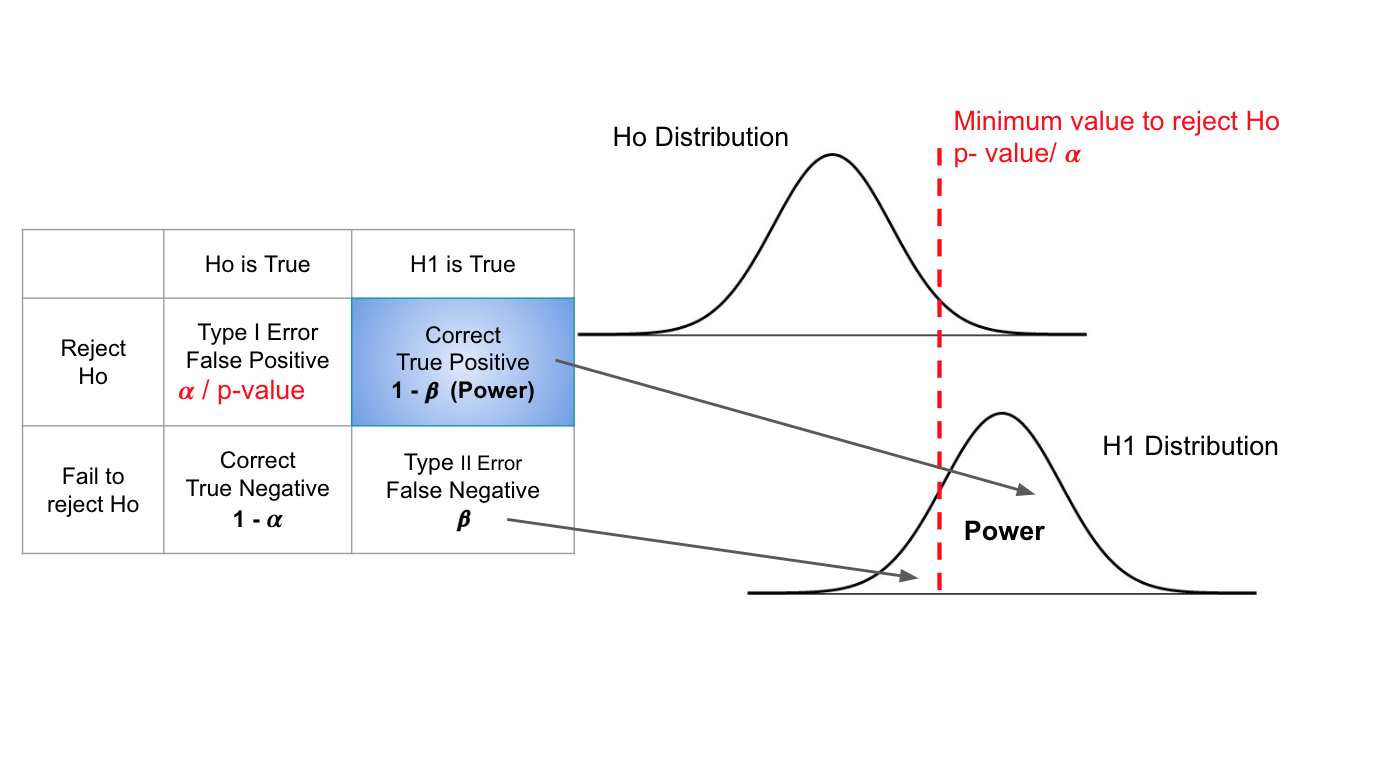

### P-Value

The lottery company says the probability of winning the ticket is 10%.   
But we found that even though we bought 897 lottery tickets only won 24 times.   
The probability should be < 10% because we only 
get 2.67%.  

**H0: p >= 10% (company claims)**  
**H1: p < 10%   (we want to prove)**  

So here we can reproduce the lottery result (win, or not win) with the Binomial Test.  

Here we will simulate 1000000 times, to see if many people do the same action as me, " buy 897 lottery tickets"
How many times do most people win?  

Me: 897, win 24 times  
Jessice: 897 win 30 times  
Tom: 897 win 43 times  
Joe: 897 win 15 times  
......  

In [1]:
import random
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

repeat_times = 1000000
sample_size = 897  # Me
prob = 0.1   # given that the lottery company said the p = 0.1 
sample_win = 24 # Me

np.random.seed(42)
simulation = np.random.binomial(n = sample_size, p = prob, size = repeat_times)

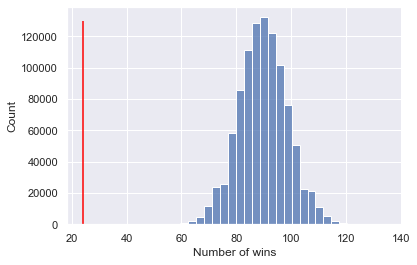

In [2]:
sns.set(style="darkgrid")
sns.histplot(data=simulation, bins=30)
plt.xlabel("Number of wins")
plt.vlines(x=sample_win,  ymin=0, ymax=130000, colors="red")
plt.show()

In [3]:
# that see how bad luck I am
me = sum(simulation <= sample_win)

print(f'After sumulate {repeat_times} times, ther are {me} count of people win the lottery <= {sample_win} ')

After sumulate 1000000 times, ther are 0 count of people win the lottery <= 24 


In [4]:
# the probability of my event, given that the lottery company claims the p=0.1.
print(f"{binom.pmf(k=24, n=897, p=0.1):.20f}")

0.00000000000000000984


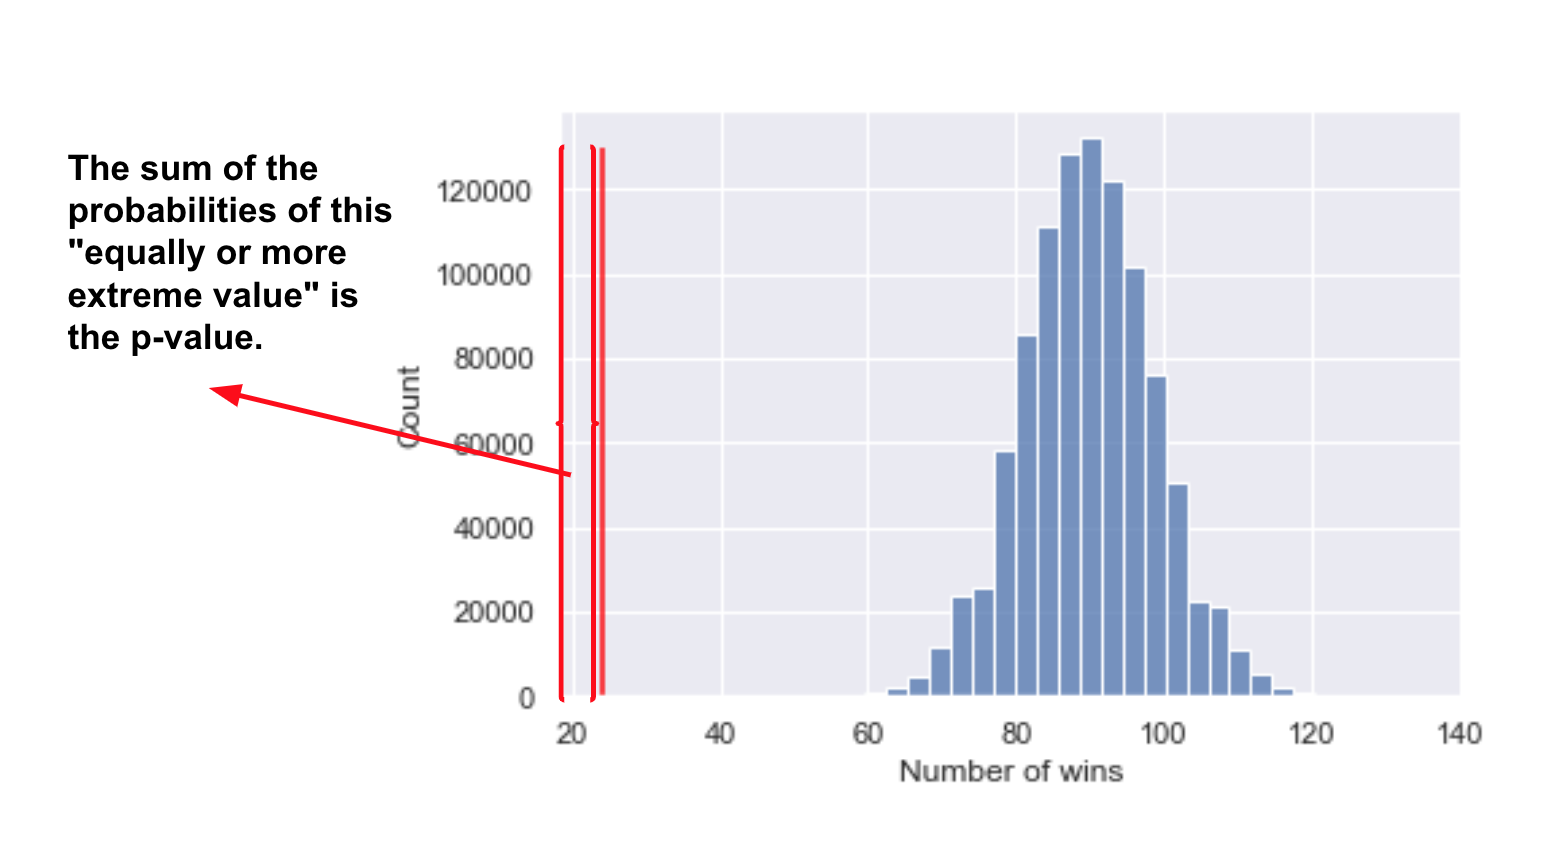

In [5]:
# p-value is the probability of win <= 24 times.
# p-value: the probability of obersering a test statistic 
# equally or more extreme than the one you observed given that the null hypothesis
# is true.

for i in range(25):
    prob = binom.pmf(k=i, n=897, p=0.1)
    print(f"The probability of win {i} times:{prob:.20f}")
    

The probability of win 0 times:0.00000000000000000000
The probability of win 1 times:0.00000000000000000000
The probability of win 2 times:0.00000000000000000000
The probability of win 3 times:0.00000000000000000000
The probability of win 4 times:0.00000000000000000000
The probability of win 5 times:0.00000000000000000000
The probability of win 6 times:0.00000000000000000000
The probability of win 7 times:0.00000000000000000000
The probability of win 8 times:0.00000000000000000000
The probability of win 9 times:0.00000000000000000000
The probability of win 10 times:0.00000000000000000000
The probability of win 11 times:0.00000000000000000000
The probability of win 12 times:0.00000000000000000000
The probability of win 13 times:0.00000000000000000000
The probability of win 14 times:0.00000000000000000000
The probability of win 15 times:0.00000000000000000000
The probability of win 16 times:0.00000000000000000000
The probability of win 17 times:0.00000000000000000000
The probability of w

In [6]:
# cdf: Cumulative distribution function
# k:24, n=897, p=0.1

p_value = binom.cdf(k=24, n=897, p=0.1)
print(f"{p_value:.20f}")

0.00000000000000001302


Conclusion: p-value is 0.00000000000000001302 < 0.05.

In short, if H0 is true, then the less than or equal to 10% chance of winning the lottery should be low(in this case, we only considered the 1-tailed), but we observed that it actually happened, so we rejected the null hypothesis.


## A/B Testing P-value
### Suppose we have run the test
A.) control group:   
    calculate the conversion rate: **con_conv**  
    control group sample size: **con_size**  
B.) test group:   
    calculate the conversion rate: **test_conv**  
    test group sample size: **test_size**  
    
The distribution of our data doesn't need to be normal,  but due to the Central Limit Theorem, our sampling distribution that has to be nearly normal, if our sample size is big enough.


In [7]:
from scipy import stats

# SEp = sqrt[ p * (1- p) / n] (standard error)
# loc = mean 

def get_pvalue(con_conv, test_conv, con_size, test_size):  
    # Conversion rate improvement is our observation target, 
    # see if less than or equal to this observation is a random occurrence
    lift =  - abs(test_conv - con_conv)  
    
    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    se = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = se )  # *2 => 2-tailed

    return p_value

In [8]:
# Suppose we have the following data

con_conv = 0.025
test_conv = 0.032
con_size = 5000
test_size = 5000

p_value_01 = get_pvalue(con_conv, test_conv,con_size,test_size )

In [9]:
print(f"{p_value_01:.20f}")

0.03538919442661064146


In [10]:
# Suppose we have the following data

con_conv = 0.01
test_conv = 0.03
con_size = 1000
test_size = 1000

p_value_02 = get_pvalue(con_conv, test_conv,con_size,test_size )

In [11]:
print(f"{p_value_02:.20f}")

0.00136210467158420301
